#**Photobleach Step Counting for the Stoichiometry of Macromolecular Complexes**

This is a presentation of the Photobleach Step Counting Method developed by me, K.Tsekouras, in the research group of Prof. S.Pressé. This method was presented in the publication:
http://www.molbiolcell.org/content/early/2016/09/19/mbc.E16-06-0404.full.pdf+html

The present notebook grew out of presentation that I  made for schoolkids, and as such it is intended primarily for a non-expert audience. However it can also be used to introduce our method and code to those interested in using it -just skip the descriptive parts and go straight for the code! 

##**What this notebook shows:**

1. What is Photobleach Step Counting, and what do we use it for
2. What are the problems we face that make this a tough job
3. What is the theory solution
4. How to run the Kalafut-Visscher algorithm to obtain basic data statistics
5. How to run our precursor algorithm to obtain an estimate of what to look for where
6. How to run our main algorithm to find step number and locations

###**1.What is Photobleach Step Counting, and what do we use it for?**
We use it to find the stoichiometry of macromolecualr complexes!

1.a:*What is a Macromolecular Complex?*
A macromolecular complex is what we call a group of hundreds or thousands of molecules (almost all proteins) that work together to do something important in a cell. They can be thought of as large machines (compared to cell sizes). There can be many kinds of molecules in a complex, and many molecules of each kind. In fact both the number of molecule kinds and the number of each kind of molecules may change while the machine works. Think of a machine that can swap out tools to do different tasks. Examples of macromolecular complexes include the Light Harvesting Complex, which is where plants catch light to make food; or the kinetochore (or kinetichore), which guides the separation of DNA when cells replicate. 

See here for a video about how the cell divides and what part the kinetochore plays: 

In [1]:
%%HTML
<iframe width="560" height="315" src="https://www.youtube.com/embed/0JpOJ4F4984" frameborder="0" allowfullscreen></iframe>

1.b:*What is Stoichiometry?*
Stoichiometry is a fancy (Greek!) term for counting how many of each kind of protein exist in a macromolecular complex at a given time. If, for example, we know that at one time (say time $t_0$), in complex A4R (just a random name), there are 21 molecules of kind A, 33 of kind B and 3 of kind C, and that no other kind of molecule is there at that time, we say we have "determined the *stoichiometry* of A4R at $t_0$".

1.c:*What is Photobleaching?*
Photobleaching is what happens when a kind of fluorescent molecule called a *fluorophore* winks out and goes dark. To understand why it is important we need to know what these fluorophores are and how they are used.

1.c.i:*What is a fluorophore?*
A fluorophore is a small molecule -a protein- that can absorb light and then re-emit it as fluorescence ("glowing"). The first fluorophores were found in corals! We can use genetic methods to insert DNA that codes for a fluorophore into the DNA that codes for any other kind of protein. Then when the cell "reads" the DNA to create the protein, it creates it with a fluorophore attached to it. If you think of a protein as a person, you can think of the fluorophore as a small monkey that is perched on the person's head. 

1.c.ii: *Why add a fluorophore to a protein?*
Because fluorophores can be turned on ("activated") with light, which we do by shining a laser on them. Once turned on, the fluorophores fluoresce (glow) for a while, and we can follow how they move or count them. Since there is one fluorophore attached to each molecule we care about - the molecule into whose code we inserted the fluorophore code- we can also follow or count the molecules. If we do this for all the molecule kinds that make up a macromolecular complex, we can determine how many of each kinf of molecules are there at any time, i.e find the complex *stoichometry*.

1.d:*So why do we need the fluorophores to "bleach" (go dark)?*
There are two kinds of experiments we do where we need fluorophores to bleach. The first one is called FRAP (Fluorescence Redistribution After Photobleaching). See below for a short video of how FRAP works:

In [2]:
%%HTML
<iframe width="560" height="315" src="https://www.youtube.com/embed/ipyGVh7JKvw" frameborder="0" allowfullscreen></iframe>

1.d (continued): The other experiment is *photobleach step counting*. When we need to count molecules, it is often not enough just to have them glow. Cells are crowded places, and other molecules may pass in front of the glowing molecules, blocking our view. Our microscopes cannot see such small things well, so the images are blurry. Often glowing molecules will be so close we cannot tell them apart. Sometimes molecules will wink out for a short time and turn back on. All of this means that when we try to count how many bright molecules are in a spot on an image, we cannot do it. However, fluorophores eventually run out of energy, and wink out for good. So people thought that if we follow the same spot in an image over time, one by one the fluorophores will wink out making the spot dimmer and dimmer. If we then make a plot where we have how bright the spot was at every time, we will see steps, times where the brightness (called "*fluorescence intensity*") abruplty drops when a fluorophore winks out. By counting the number of drops, we can find out how many molecules we have. Run the code below to see what such a plot should look like:  

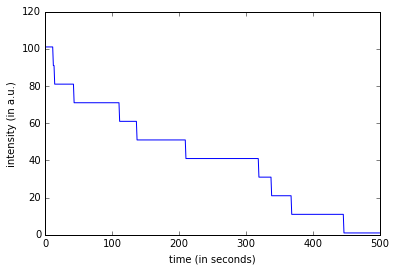

In [3]:
import numpy as np
import random as rd

# to make this notebook's output stable across runs
rd.seed(42)

data0=np.zeros(500)
steps = 10
loc = sorted(rd.sample(xrange(500),steps))
bckg = 1.0
flevel = 10.0
counter = steps
for i in range (0,500,1):
    if i in loc:
        counter -= 1
        data0[i] = flevel*counter + bckg
    else:
        data0[i] = flevel*counter + bckg

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(data0)
plt.xlabel('time (in seconds)')
plt.ylabel('intensity (in a.u.)')
plt.show()


Easy isn't it? We can see where the fluoresence intensity fell, and count 10 steps, which means we had 10 molecules! Note that even after all molecules wink out a little bit of fluoresnce remains: that is called the background, and comes out of other things that fluoresce (glow) well, in the background. If you see the title of the y-axis, it also tells you we measured the fluorescence intesity in "a.u" which means "arbitrary units" which just measn we pick some way to count intensity. Time on the other hand is measured in seconds. 

###**2. What are the problems we face that make this a tough job?**

Now that above is what such a plot should look like ** *in theory* **. In practice, things are much tougher, because all the problems I mentioned earlier (crowded cells, blinks, one molecule on top of another, etc etc) make the plot a lot less clear: they add "noise", in other words they make intensity jump up and down at random. What is worse, the more fluorophores we have, the larger the jumps! Run the code below to see what a plot looks like when there is noise:

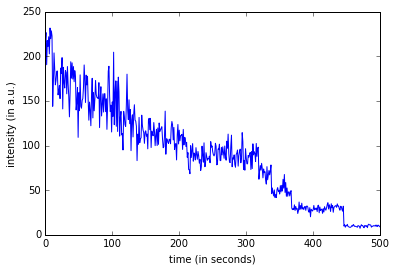

In [4]:
# to make this notebook's output stable across runs
rd.seed(42)

data1=np.zeros(500)
steps = 10
loc = sorted(rd.sample(xrange(500),steps))
bckg = 10.0
flevel = 20.0
std_bckg = 1.0
std_flevel = 2.5
counter = steps
for i in range (0,500,1):
    if i in loc:
        counter -= 1
        data1[i] = counter*rd.gauss(flevel,std_flevel) + rd.gauss(bckg,std_bckg)
    else:
        data1[i] = counter*rd.gauss(flevel,std_flevel) + rd.gauss(bckg,std_bckg)

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(data1)
plt.xlabel('time (in seconds)')
plt.ylabel('intensity (in a.u.)')
plt.show()

Now finding the steps in this plot is much harder! Late in the plot when most fluorophores have bleached (winked out)  we can still see the steps, but early on noise makes everything a blur. To manage to find steps when plots look like this we used the mathematical tools of **Bayesian inference**. Below I have only a high-level overview of the math; if you are interested in detils or the nitty-gritty, take a look at [our_paper.](http://www.molbiolcell.org/content/early/2016/09/19/mbc.E16-06-0404.full.pdf+html)

###**3. What is the theory solution?**

Well, we have data (our plot) and want to find how many steps are in it and where they are. There are many possible numbers of steps and arrangements for those steps in the plot. Let us call each such arrangement of a given number of steps $A_i$. For example, $A_5$ might be an arrangement where we have two steps at positions 5 and 213 of our plot.
$A_{101}$ may have three steps at positions 2, 111 and 402, and so on. We call the total number of positions in our plot the *number of data points*. Obviously, if we have, say, 400 data points, there are only 400 positions and $A_{101}$, which has a step at 402, is not possible. What we need to find is which $A_i$ is more likely given the plot. If we call our plot B, in the language of probability we want to compare the probabilities $P(A_i|B)$, i.e the probabilities of arrangements $A_i$ given the particular data (plot) B we are studying. The arrangement with the largest $P(A_i|B)$ is the one most likely to be true.

We use ** *[Bayes' Theorem](http://en.wikipedia.org/wiki/Bayes%27_theorem)* **: $P(B)P(A_i|B)=P(B|A_i)P(A_i)\rightarrow P(A_i|B)=\frac{P(B|A_i)P(A_i)}{P(B)}$.

Here $P(B|A_i)$ is the probability of getting the plot we have if the arrangement $A_i$ is correct: we call it the *[likelihood function](http://en.wikipedia.org/wiki/Likelihood_function)*. $P(B)$ is the probability of the plot we have, and $P(A_i)$ is the probability of arrangement $A_i$ and is called the *[prior](http://en.wikipedia.org/wiki/Prior_probability)*. Therefore, instead of finding the largest $P(B|A_i)$, we can find the largest $P(B|A_i)P(A_i)$; we can drop $P(B)$ becasue it does not change for different $A_i$.  

We can use what we know about photobleach step experiments and fluorophores to make a good guess at the prior. We can also make some assumptions to find the likelihhod function: the most important of these assumptions are that a) the emmision due to a single fluorophore follows the [normal distribution](http://en.wikipedia.org/wiki/Normal_distribution) and b) the intensity and noise from different fluorophores add up. These assumptions are pretty safe bets as they are based both on logic and on what experimental scientists have observed actually happening in the lab. 

After some work, we find a mathematical formula we can use to compare different $A_i$s:
$\sum_{\phi=0}^K\left(n_\phi\ln(i\sigma_f^2+\sigma_b^2) + \sum_{l=1}^{n_\phi}\frac{(x_l-i\mu_f-\mu_b)^2}{i\sigma_f^2+\sigma_b^2}\right)$
$ +2\left(-K\ln\lambda-\ln((m-K)!) -\ln(K!)+\ln((m-1)!)+\sum_{y=0}^{m-K}\ln(d_y!) +\gamma_0\frac{m-K+1}{K}\right)$
$+2\left(\ln(m-K+2)+\ln(m-K+1)-\ln\left(A\right)\right)$ 
where $A =m-K+2-(m-K+1)e^{-\gamma_0/K}$.

This formula is the negative log of $P(A_i|B)$; it is easier to work with than with $P(A_i|B)$ itself for computational reasons. Here $K$ is the number of steps, $n_{\phi}$ the number of data points between steps, $\mu_f$, $\mu_b$, $\sigma^2_f$ and $\sigma^2_b$ the means and variances of the emissions of the single fluorophore and the background respectively, $x_l$ is the particular data point, $\lambda$ a constant *Poisson rate* and $d_y$ the *degeneracies* of step sizes. $m$ is the number single fluorophores that photobleach - it may not be the same as the number of steps, since more than one fluorophore can photobleach simultaneously, and $\gamma_0$ is a [hyperparameter](http://en.wikipedia.org/wiki/Hyperparameter) of our model.   








Now to use this formula, we need to know all the quantities in it. Some we do: $K,m,d_y$ and $n_{\phi}$ are determined by the arrangement $A_i$ whose probability we are trying to find, while $x_l$ is given by our data. We can easily estimate the Poisson rate $\lambda$; turns out that it plays a very small role so even a very crude estimate is OK.
This leaves $\mu_f$, $\mu_b$, $\sigma^2_f$ and $\sigma^2_b$. Now sometimes, if the scientists who got the data have measured them, we may know them. If they have not, we need to find them. To do so, we employ an algorithm by Kalafut & Visscher. This algorithm was meant to find steps in data where the noise is constant, unlike ours where noise changes as fluorophores photobleach. 

###**4. How to run the Kalafut-Visscher algorithm to obtain basic data statistics**

We will start by loading some data.

number of datapoints: 1200
First step: 281
mean and variance of background: 1163 and 26950
mean and variance of single fluorophore: 1517 and 77856


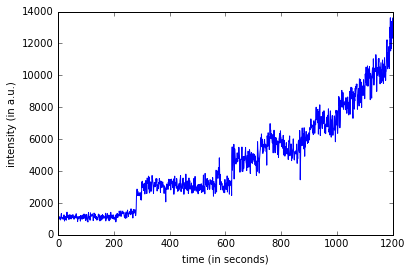

In [5]:
#We import the Kalafut-Visscher algorithm
from KalafutPUB import KalafutC
#We import some data:
zignal = np.loadtxt("TestDataSet00.txt", unpack=True)  
#This is real experimental data from the lab of Y.Krishnan at U. Chicago. 
#This means we have no idea where the steps actually are.
#We reverse the plot here; see part 4 below for the reason.
signal = zignal[::-1]
Try1 = KalafutC(signal)
stats = Try1.stats
tzero = Try1.tzero

print "number of datapoints:",len(signal)
print "First step:", tzero
print "mean and variance of background:", int(stats[0]),"and",int(stats[1])
print "mean and variance of single fluorophore:", int(stats[2]),"and",int(stats[3])

#%matplotlib inline
#import matplotlib.pyplot as plt
plt.plot(signal)
plt.xlabel('time (in seconds)')
plt.ylabel('intensity (in a.u.)')
plt.show()

This gives us the quantities $\mu_b$, $\sigma^2_f$, $\mu_f$ and $\sigma^2_b$ we need to run our formula. 
We can easily check whether these are in the ballpark; we do not need them to be exact! We can eyeball the first step in the reversed plot as being around 280. Let us find the mean and variance of a stretch of the plot before that point, the mean of another stretch of the plot just after that point, and the variance of yet another stretch of the plot further along the plot:

In [6]:
mb = np.mean(signal[100:250])
vb = np.var(signal[100:250])
mf = np.mean(signal[280:320]) - mb
vf = np.var(signal[280:500]) - vb
print "mean and variance of background:", int(mb),"and",int(vb)
print "mean and variance of single fluorophore:", int(mf),"and",int(vf)

mean and variance of background: 1161 and 23951
mean and variance of single fluorophore: 1625 and 84073


We can see that the values found by the Kalafut-Visscher algorithm are pretty close to those we found by simply looking at the mean and variance of data around the first step. We now have values for all the parameters we need to code and run our formula that will determine which arrangement $A_i$ is the most probable. 

However, if we try to do this right away, we will find that even for a small data set of only 1200 data points, like the one we used above, our method will take forever to work. Why? Well because the number of possible arrangements to be considered is enormous. Let us say we want to find which 12-step arrangement is most likely. How many 12-step arrangements can there be in a 1200 data point data set? Mathematics gives us the answer: ${N \choose K}=\frac{N!}{K!(N-K)!}$, where $N$ is the number of data points and $K$ the number of steps. For $N=1200$, $K=12$, this number is approximately 1 followed by 28 zeros. And that is without counting arrangements where there are two steps at the same time! And our formula needs to compare all arrangements for various numbers of steps, from none to 1200. This would take so much time we might as well not do it.

What we need is a way to limit the number of arrangements to be considered. This is often done using a [greedy algorithm](http://en.wikipedia.org/wiki/Greedy_algorithm), but in our case even that is too slow, and would make the code for our formula run for days. To overcome this problem, we use a *precursor algorithm*. 

###**5. How to run our precursor algorithm to obtain an estimate of what to look for where**

Our precursor algorithm is a fast and simple program that divides our data into slices (called "windows") whose size we choose arbitrarily. It then proceeds to find a crude estimate of how many fluorophores are active (have not photobleached) in each window. We do this on the time-reversed data (this is why we reversed the plot above, though tht was not necesary at the time), because that way we know we start when all fluorophores have photobleached (since in experiments we wait until that has happened). To see how this helps, see below , part 6. For now let us see how it works: 

In [7]:
from SeekerPUB import Slicer

#We pass into the precursor algorithm the data, window size, the number of fluorophores the reversed trace starts with 
#(0, since all have photobleached) and the statistics found by Kalafut-Visscher above.
#Note that the number of data points must always be an integer multiple of the window size (windsz)
windsz = 100
Prelook = Slicer(signal,windsz,0,stats) 

#The precursor algorithm will now divide the 1200 data points by 100, and look into each of the resulting 12 windows.
#It will print "Step 2 'window number' " for each successfully processed window. 
#The 12 steps are numbered in the pythonic way, 0 to 11.

#Here is the approximate number of fluorophores active in each window:
print Prelook.fosfor

Step 2 0
Step 2 1
Step 2 2
Step 2 3
Step 2 4
Step 2 5
Step 2 6
Step 2 7
Step 2 8
Step 2 9
Step 2 10
Step 2 11
[ 0.  0.  0.  1.  1.  1.  2.  3.  3.  4.  5.  5.]


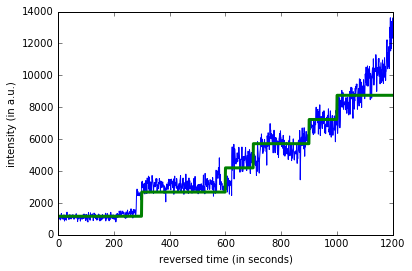

In [10]:
#We can use these to see an estimate of what the precursor algorithm thinks the data ought to look like without noise,
#and compare this to the actual data
precurs = np.zeros(len(signal))
for i in range(0,len(precurs),1):
    j = i//windsz
    precurs[i] = Prelook.fosfor[j]*stats[2] +stats[0] 

dx = np.arange(0,len(signal))
    
plt.figure(1)
plt.plot(dx, signal)
plt.plot(dx, precurs, linewidth=3.0)
plt.xlabel('reversed time (in seconds)')
plt.ylabel('intensity (in a.u.)')
plt.show()

Here blue is our data and red the result of the precursor algorithm. You can see that the algorithm sometimes agrees well with the data, sometimes less so, and the steps are, far as we can tell by eye, close but not quite where they ought to be. That is OK; the job of the precursor algorithm is not to be exact, but rather to allow us to start our main algorithm, the one that codes the formula, from an estimate close to the best, so we can constrain our search and reduce the time needed to reach a conclusion. As the main algorithm processes each data window, it will take the precursor algorithm estimate for that window as the starting point for a local search. For example, say that the main algorithm begins to process a window which the precursor algorithm has found is most likely to have 5 fluorophores active. If the main algorithm has found that at the end of the previous window there were just two fluorophores active, it starts by assuming that somewhere within the current window there are three steps. It will therefore calculate the probabilities of all 3-step arrangements in that window and pick the most likely one. Having done that, it will do the same for arrangements with 2 steps and 4 steps. It will then compare the probabilities of the most likley 2-step, 3-step and 4-step arrangements. If the most likely 3-step arrangement is the most probable of the three, the algorithm accepts it as correct and moves to the next window. If, say, the most likely 4-step arrangement is more likely, then the algorithm finds the most probable 5-step arrangmement and compares; if the 4-step is more likely it is accepted as true, else the most likely 6-step arrangement is calculated and so on.


See how to use our main algorithm below:

###**6. How to run our main algorithm to find step number and locations**

We are now ready to run our main code. Note that even for a small data set like this one, we will still need about 15 mins, even with all the effort we made to speed things up. 


In [9]:
from LeffFinderPUB import LbarFind, PriorSlicer
from SeekerPUB import mSICer

#This finds an array of estimates for the parameter λ. The main code then automatically chooses the best estimate
#to use. This parameter plays only a minor role and can be way off without repercussions to our method accuracy.
calba = LbarFind(signal, stats, tzero, 0)                                   
lbar = calba.Lbar                                                
zamm = PriorSlicer(signal, lbar, tzero, 0)   
lefaray = zamm.leffarray  

widd = len(signal)/windsz

fluor = 0
stepsC = np.zeros(1)
for i in range(0,widd,1):
    mSIClook = mSICer(signal, i, fluor, windsz, stats, len(signal), lefaray)                                                                     
    steps_found = mSIClook.SIClocs                                            
    stepsCi = np.zeros_like(steps_found)
    levelz = fluor
    for j in range(0,len(steps_found),1):                                     
        stepsCi[j] = levelz
        levelz += steps_found[j]
    fluor = mSIClook.fluorOUT
    stepsC = np.concatenate((stepsC,stepsCi))  
stepsC = stepsC[1:]


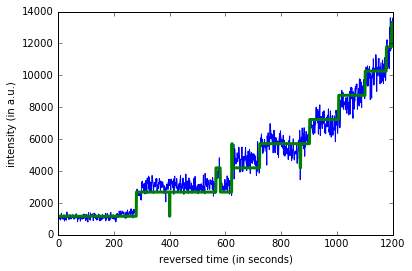

number of steps: 15
total fluorophores: 8


In [11]:
#We can now see the results of our effort:
result = np.zeros(len(signal))
for i in range(0,len(stepsC),1):
    result[i] = stepsC[i]*stats[2] +stats[0] 

plt.figure(1)
plt.plot(dx, signal)
plt.plot(dx, result, linewidth=3.0)
plt.xlabel('reversed time (in seconds)')
plt.ylabel('intensity (in a.u.)')
plt.show()

#We can also count the number of steps:
diffcount = np.diff(stepsC)
acount = np.where(diffcount!=0)
stepcount = len(acount[0])

print "number of steps:", stepcount
#and find what the maximum number of fluorophores that were ever active was:
maxfluors = np.nanmax(stepsC)
print "total fluorophores:", int(maxfluors)


Results are very good, esp. later in the reversed data set, which we care more about because that is where noise is highest and the number and locations of steps harder to find. There are, however, a couple of issues: there are a few stretches where the result seems to be at a fluorescence intesity level lower than the data (say between 400 and 600), plus there are two downward spikes at about 400 and 875 which seem strange. The stretches that seem to be not quite right usually indicate that one of the model parameters needs tuning: either the window size or, more likely, the hyperparameter $\gamma_0$. However, the spikes are a known artifact that arises out of small number statistics when a potential step is very close to a window edge. Running the code again with a different window size so that the windows for the second run do not have edges at the same points as those for the first run typically yields the same result but with the spikes moved or eliminated. Superposing the two results and eliminating spikes that are not identical in both removes artifact features. Note that the total number of steps includes these spikes counted as two steps each; removing them for the above data set would drop the number of steps from 15 to 11. In general, since two fluorophores bleaching at the same time is a rare event, seeing big differences in the counts of steps and fluorophores is a sign you should look more closely at your parameter choices. 

It is possible to use this notebook to run your own data sets. However, its functionality is limited, as it is intended largely as an introductory presentation. The User Guide offers an in-depth explanation of all the tunable parameters in the code, and you can get full functionality by running the code at the command line after tailoring those parameters to your problem.   

Should have questions or encounter issues, please do not hesitate to contact me at tamytes8a@gmail.com.

K. Tsekouras









